### In this nootebook Cascade RCNN from MMDET library pretrained on VizdroneDataset2019Det will train and test on data from competition to detect people in aerial photographs

In [ ]:
%pip install -U openmim
!mim install mmcv-full

In [ ]:
%pip install -U albumentations

In [ ]:
%pip install mmdet

In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -v -e .

In [ ]:
import pandas as pd
import json
import mmcv
import numpy as np
import albumentations as A
import os
import cv2
from tqdm import tqdm
import re

# Change data format (bounding circles to bounding boxes) and define *get annotations function*

In [ ]:
df = pd.read_csv('/content/train.csv')

In [ ]:
annotations = []

In [ ]:
train_path = '/content/drive/MyDrive/dataset/train/'
test_path = '/content/drive/MyDrive/dataset/test/'

In [ ]:
def get_anno(data_path):
    bboxes_dict = {}
    annotations = []
    for idx in tqdm(df.index):
        record = df.loc[idx]
        anno = {'filename': record['ID_img']}
        image = mmcv.imread(f'{data_path}{record["ID_img"]}')
        anno['height'], anno['width'] = image.shape[:2]
        anno['ann'] = {}
        if df.loc[idx, 'count_region'] > 0:
            bounding_circles = [eval(elem) for elem in re.findall('{"cx":\d+,"cy":\d+,"r":\d+}', 
                                                                  df.loc[idx]['region_shape'])]
            anno['ann']['bboxes'] = np.array([[max(0, c['cx']-c['r']), max(0, c['cy']-c['r']),
                                               min(anno['width'], c['cx']+c['r']), min(anno['height'], c['cy']+c['r'])]
                                              for c in bounding_circles], dtype=np.float32).reshape(-1, 4)
            anno['ann']['labels'] = np.array([0 for _ in range(len(bounding_circles))], dtype=np.long)
            bboxes_dict[record['ID_img']] = [[max(0, c['cx']-c['r']), max(0, c['cy']-c['r']),
                                               min(anno['width'], c['cx']+c['r']), min(anno['height'], c['cy']+c['r'])]
                      for c in bounding_circles]
        else:
            anno['ann']['bboxes'] = np.array([], dtype=np.float32).reshape(-1, 4)
            anno['ann']['labels'] = np.array([], dtype=np.long)
        annotations.append(anno)
    return annotations, bboxes_dict

MMDetection middle format of data
```
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4),
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]
```

In [ ]:
annotations, bboxes_dict = get_anno(train_path)

# Upsample dataset

Since the number of images where people are actually present is too small (58), we use various transformations to generate similar images and add them to the dataset

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.ShiftScaleRotate(rotate_limit = 15, p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussNoise(p=0.5),
    A.Cutout(num_holes=5, max_h_size=200, max_w_size=200),
    A.RandomCropFromBorders(crop_left = 0.2, crop_right = 0.2, crop_top = 0.2, crop_bottom = 0.2, 
                            p=0.5)
], bbox_params=A.BboxParams(format='pascal_voc', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

In [ ]:
def upsample_dataset(data_path, transforms, bboxes_dict, annotations):
    new_annotations = annotations.copy()
    save_path = '/content/transformed_imgs/'
    for i in range(6):
        for img_name in tqdm(bboxes_dict.keys()):
            anno = {}
            image = cv2.imread(f'{data_path}{img_name}')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            transformed = transform(image=image, bboxes=bboxes_dict[img_name], 
                                    class_labels=['person' for _ in range(len(bboxes_dict[img_name]))])
            transformed_image = transformed['image']
            transformed_bboxes = transformed['bboxes']
            cv2.imwrite(f'{data_path}{i}_{img_name}', transformed_image)
            anno['filename'] = f'{i}_{img_name}'
            anno['height'], anno['width'] = image.shape[:2]
            anno['ann'] = {}
            anno['ann']['bboxes'] = np.array(transformed_bboxes, dtype=np.float32).reshape(-1, 4)
            anno['ann']['labels'] = np.array([0 for _ in range(len(transformed_bboxes))], dtype=np.long)
            new_annotations.append(anno)
    return new_annotations

In [ ]:
new_annotations = upsample_dataset(train_path, transform, bboxes_dict, annotations)

  0%|          | 0/58 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 58/58 [01:47<00:00,  1.85s/it]


# Register competetition dataset

In [ ]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
import numpy as np
from tqdm import tqdm

@DATASETS.register_module()
class AerialPhotoDataset(CustomDataset):
      CLASSES = ('Person', )
      transform = None
      test_mode = False
      def load_annotations(self, ann_file):
          annotations, bboxes_dict = get_anno(self.data_root)
          if not self.test_mode:
              annotations = upsample_dataset(self.data_root, self.transform, bboxes_dict, annotations)
          return annotations

# Load and modify config file

In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/dcn/cascade_rcnn_r101_fpn_dconv_c3-c5_1x_coco.py')

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'AerialPhotoDataset'
cfg.data_root = '/content/drive/MyDrive/dataset/'

cfg.data.test.type = 'AerialPhotoDataset'
cfg.data.test.data_root = '/content/drive/MyDrive/dataset/test/'
cfg.data.test.ann_file = '/content/train.csv' #???
cfg.data.path = test_path
cfg.data.test.img_prefix = ''

cfg.data.train.type = 'AerialPhotoDataset'
cfg.data.train.data_root = '/content/drive/MyDrive/dataset/train/'
cfg.data.train.ann_file = '/content/train.csv' 
cfg.data.transform = transform
cfg.data.train.img_prefix = ''

# modify num classes of the model in box head
for layer in cfg.model.roi_head.bbox_head:
    layer.num_classes = 1
cfg.load_from = '/content/drive/MyDrive/models/model3.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/training_on_real_data'

cfg.optimizer.lr = 0.02 / 12
cfg.lr_config.warmup_ratio = 1e-4
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = 'cuda'
cfg.runner.max_epochs = 6
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


# Build dataset and model and train detector

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

In [ ]:
train_detector(model, datasets, cfg, distributed=False, validate=False)

# Inference model

In [ ]:
from mmdet.apis import init_detector, inference_detector
from mmdet.models import build_detector
from PIL import Image
from torchvision.utils import draw_bounding_boxes
from torchvision import transforms
import torch
import pandas as pd

In [ ]:
#Влияет на то, какие bounding boxes будут попадать в ответ
#cfg.model.test_cfg.rcnn.score_thr = 0.3 # только с уверенностью модели большей score_thr
cfg.model.test_cfg.rcnn.nms.iou_threshold = 0.30

In [ ]:
# Build the detector
model = init_detector(
    cfg, '/content/drive/MyDrive/models/model_2.pth')

In [ ]:
def get_prediction(model, img_path):
    answer = []
    results = inference_detector(model, img_path)[0]
    probs = results[:, 4]
    if len(probs) == 1:
        return results
    else:
        for i in range(1, len(probs)):
            if i > 0 and probs[i] - probs[i-1] > 0.2:
                return results[:(i+1)]
        else:
            length = sum(probs > 0.3)
            return results[:length]
            

# Get predictions for all test data

In [ ]:
submission = pd.read_csv('/content/sample_solution.csv')

In [ ]:
test_path = '/content/drive/MyDrive/dataset/test/'
results = []
for img_name in tqdm(submission['ID_img']):
    res = get_prediction(model, f'{test_path}{img_name}')
    results.append(res)

100%|██████████| 3435/3435 [46:37<00:00,  1.23it/s]


#bboxes to circles

In [ ]:
def bbox_to_circle(bboxes):
  brounds = []
  for bbox in bboxes:
    cx = int((bbox[0]+bbox[2])//2)
    cy = int((bbox[1]+bbox[3])//2)
    r = int((abs(bbox[2] - bbox[0]) + abs(bbox[3] - bbox[1])) // 4)
    brounds.append(f'{{"cx":{cx}, "cy":{cy}, "r":{r}}}')
  return brounds

In [ ]:
region_shape_column = [0 for x in range(submission.shape[0])]
for i in range(len(results)):
    if len(results[i]) != 0:
        region_shape_column[i]=bbox_to_circle(results[i])
submission["region_shape"] = region_shape_column

In [ ]:
submission.to_csv('/content/submission4.csv', index=False)

#Vizualize predictions

In [ ]:
def vizualize_prediction(model, path):
    results = inference_detector(model, path)
    print(results)
    img = Image.open(path).convert('RGB')
    transform = transforms.PILToTensor()
    tensor = transform(img)
    transform = transforms.ToPILImage()
    result_img = transform(draw_bounding_boxes(tensor, torch.tensor([box[:4] for box in results[0]]), width=5))
    result_img = result_img.resize((1024,1024))
    display(result_img)

[array([[2.0382164e+03, 1.3100054e+03, 2.2458901e+03, 1.4992028e+03,
        6.2882894e-01],
       [1.7970874e+03, 1.3353082e+03, 1.9905691e+03, 1.5357610e+03,
        5.6631678e-01],
       [1.9775909e+03, 1.4559015e+03, 2.1022166e+03, 1.5845035e+03,
        5.2402866e-01],
       [1.1444230e+03, 1.5392948e+03, 1.3044440e+03, 1.7246875e+03,
        4.3551439e-01],
       [1.9260500e+03, 1.4234990e+03, 2.0315995e+03, 1.5391753e+03,
        3.6729571e-01]], dtype=float32)]


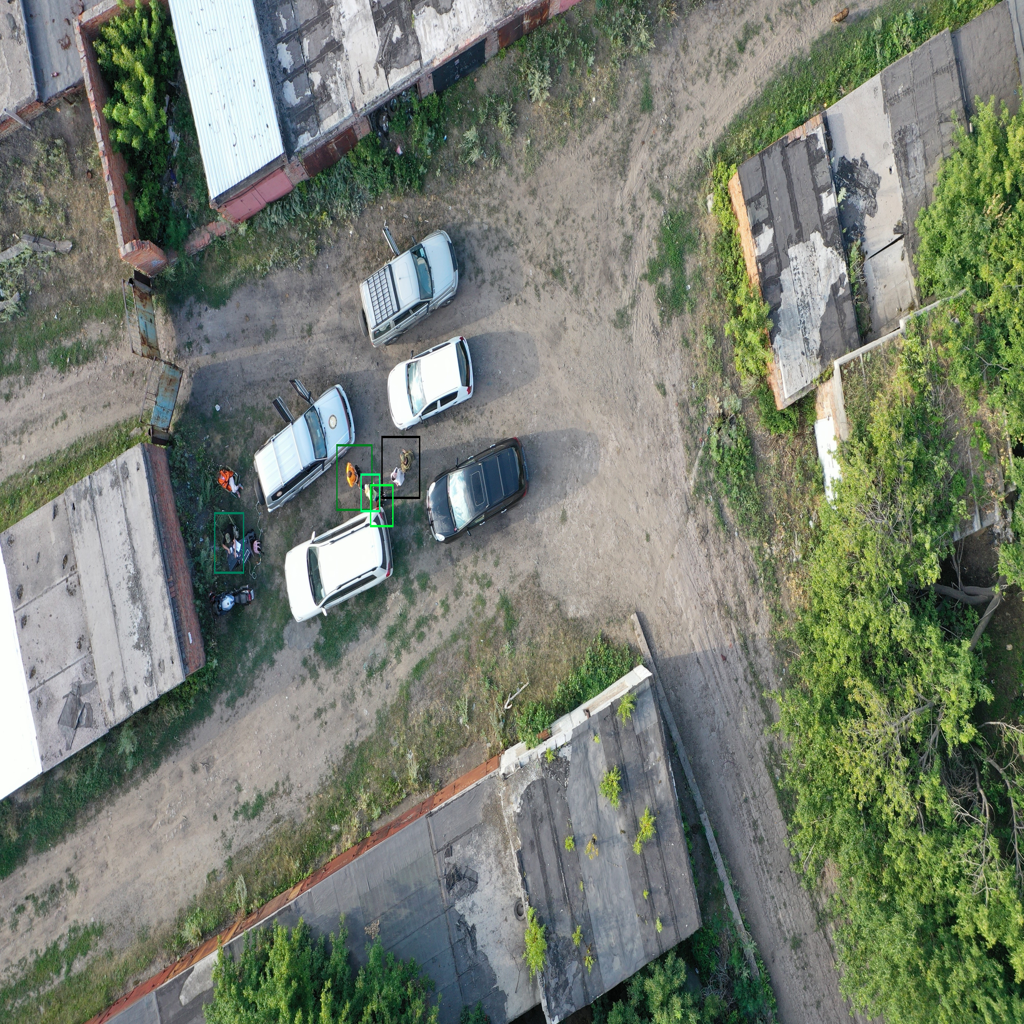

In [ ]:
vizualize_prediction(model, '/content/drive/MyDrive/dataset/test/3322.JPG')